# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from visualize import Visualizer
from metrics import f1_fn, cohen_kappa_fn
from models import PretrainedCNNClassifier
from torch import nn
from optim_utils import build_optimizer_and_scheduler
from torchsummary import summary
from torchvision import transforms
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

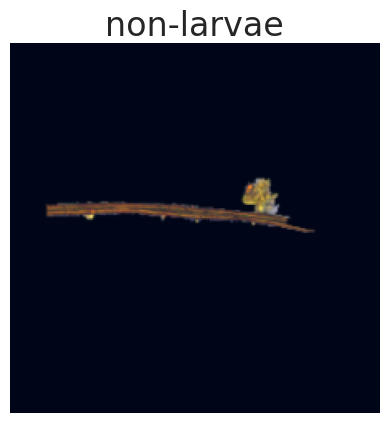

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config_mlp = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

optim_config_fine = {
    "scheduler": "onecycle",
    "max_lr": 5e-5,
    "lr": 1e-5,
    "eta_min": 1e-7,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = PretrainedCNNClassifier(
    num_classes=num_classes,
    backbone="mobilenet_v2",
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
ckpt_cnn_0 = "weights/larvae-pre-cnn-0.pt"

#### Train MLP

In [12]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config_mlp,
    train_loader_len=len(train_loader),
    total_epochs=100,
)

trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [13]:
cnn_0.freeze_backbone()
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6804 | Val Loss: 0.6713 | Train cohen_kappa_fn: 0.0176 | Val cohen_kappa_fn: 0.0193 | Train f1_fn: 0.1039 | Val f1_fn: 0.1119
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6384 | Val Loss: 0.6433 | Train cohen_kappa_fn: 0.3356 | Val cohen_kappa_fn: 0.3328 | Train f1_fn: 0.7755 | Val f1_fn: 0.7615
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6025 | Val Loss: 0.6115 | Train cohen_kappa_fn: 0.4938 | Val cohen_kappa_fn: 0.5060 | Train f1_fn: 0.8648 | Val f1_fn: 0.8793
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5531 | Val Loss: 0.5745 | Train cohen_kappa_fn: 0.4730 | Val cohen_kappa_fn: 0.4519 | Train f1_fn: 0.8588 | Val f1_fn: 0.8443
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5129 | Val Loss: 0.5113 | Train cohen_kappa_fn: 0.6781 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9371 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4772 | Val Loss: 0.4807 | Train cohen_kappa_fn: 0.7496 | Val cohen_kappa_fn: 0.7766 | Train f1_fn: 0.9559 | Val f1_fn: 0.9647
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4372 | Val Loss: 0.4637 | Train cohen_kappa_fn: 0.5459 | Val cohen_kappa_fn: 0.5226 | Train f1_fn: 0.8894 | Val f1_fn: 0.8807
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4083 | Val Loss: 0.4595 | Train cohen_kappa_fn: 0.5061 | Val cohen_kappa_fn: 0.4859 | Train f1_fn: 0.8728 | Val f1_fn: 0.8613
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3600 | Val Loss: 0.4343 | Train cohen_kappa_fn: 0.5412 | Val cohen_kappa_fn: 0.5171 | Train f1_fn: 0.8865 | Val f1_fn: 0.8755
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3476 | Val Loss: 0.4108 | Train cohen_kappa_fn: 0.5456 | Val cohen_kappa_fn: 0.5225 | Train f1_fn: 0.8872 | Val f1_fn: 0.8778
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3065 | Val Loss: 0.3988 | Train cohen_kappa_fn: 0.5346 | Val cohen_kappa_fn: 0.5012 | Train f1_fn: 0.8860 | Val f1_fn: 0.8685
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2938 | Val Loss: 0.3868 | Train cohen_kappa_fn: 0.5126 | Val cohen_kappa_fn: 0.5171 | Train f1_fn: 0.8733 | Val f1_fn: 0.8755
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2526 | Val Loss: 0.3557 | Train cohen_kappa_fn: 0.6110 | Val cohen_kappa_fn: 0.5338 | Train f1_fn: 0.9114 | Val f1_fn: 0.8852
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2628 | Val Loss: 0.3361 | Train cohen_kappa_fn: 0.5983 | Val cohen_kappa_fn: 0.5629 | Train f1_fn: 0.9070 | Val f1_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2225 | Val Loss: 0.3315 | Train cohen_kappa_fn: 0.6091 | Val cohen_kappa_fn: 0.5511 | Train f1_fn: 0.9116 | Val f1_fn: 0.8921
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2345 | Val Loss: 0.3143 | Train cohen_kappa_fn: 0.6601 | Val cohen_kappa_fn: 0.5968 | Train f1_fn: 0.9290 | Val f1_fn: 0.9127
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2328 | Val Loss: 0.3136 | Train cohen_kappa_fn: 0.6562 | Val cohen_kappa_fn: 0.5968 | Train f1_fn: 0.9272 | Val f1_fn: 0.9127
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2177 | Val Loss: 0.3040 | Train cohen_kappa_fn: 0.6320 | Val cohen_kappa_fn: 0.5837 | Train f1_fn: 0.9205 | Val f1_fn: 0.9084
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1984 | Val Loss: 0.2858 | Train cohen_kappa_fn: 0.7211 | Val cohen_kappa_fn: 0.6190 | Train f1_fn: 0.9457 | Val f1_fn: 0.9216
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1946 | Val Loss: 0.2881 | Train cohen_kappa_fn: 0.6597 | Val cohen_kappa_fn: 0.5825 | Train f1_fn: 0.9270 | Val f1_fn: 0.9058
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1913 | Val Loss: 0.2804 | Train cohen_kappa_fn: 0.6807 | Val cohen_kappa_fn: 0.6170 | Train f1_fn: 0.9349 | Val f1_fn: 0.9191
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.1946 | Val Loss: 0.2908 | Train cohen_kappa_fn: 0.6430 | Val cohen_kappa_fn: 0.5647 | Train f1_fn: 0.9219 | Val f1_fn: 0.9018
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1755 | Val Loss: 0.2779 | Train cohen_kappa_fn: 0.7275 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9473 | Val f1_fn: 0.9255
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1779 | Val Loss: 0.2804 | Train cohen_kappa_fn: 0.6431 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.9239 | Val f1_fn: 0.8974
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1531 | Val Loss: 0.2758 | Train cohen_kappa_fn: 0.6579 | Val cohen_kappa_fn: 0.5762 | Train f1_fn: 0.9271 | Val f1_fn: 0.9036
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.1856 | Val Loss: 0.3056 | Train cohen_kappa_fn: 0.5522 | Val cohen_kappa_fn: 0.5226 | Train f1_fn: 0.8889 | Val f1_fn: 0.8807
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1720 | Val Loss: 0.2789 | Train cohen_kappa_fn: 0.6276 | Val cohen_kappa_fn: 0.5517 | Train f1_fn: 0.9177 | Val f1_fn: 0.8947
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1772 | Val Loss: 0.3023 | Train cohen_kappa_fn: 0.6008 | Val cohen_kappa_fn: 0.5226 | Train f1_fn: 0.9079 | Val f1_fn: 0.8807
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1840 | Val Loss: 0.2723 | Train cohen_kappa_fn: 0.6718 | Val cohen_kappa_fn: 0.6102 | Train f1_fn: 0.9324 | Val f1_fn: 0.9170
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1593 | Val Loss: 0.2745 | Train cohen_kappa_fn: 0.6467 | Val cohen_kappa_fn: 0.5699 | Train f1_fn: 0.9237 | Val f1_fn: 0.9014
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1674 | Val Loss: 0.2742 | Train cohen_kappa_fn: 0.6533 | Val cohen_kappa_fn: 0.5531 | Train f1_fn: 0.9264 | Val f1_fn: 0.9000
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1452 | Val Loss: 0.2548 | Train cohen_kappa_fn: 0.7637 | Val cohen_kappa_fn: 0.6261 | Train f1_fn: 0.9552 | Val f1_fn: 0.9237
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.1490 | Val Loss: 0.2734 | Train cohen_kappa_fn: 0.6854 | Val cohen_kappa_fn: 0.5404 | Train f1_fn: 0.9356 | Val f1_fn: 0.8929
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1587 | Val Loss: 0.2645 | Train cohen_kappa_fn: 0.6757 | Val cohen_kappa_fn: 0.5538 | Train f1_fn: 0.9311 | Val f1_fn: 0.9026
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1588 | Val Loss: 0.2636 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.5709 | Train f1_fn: 0.9432 | Val f1_fn: 0.9040
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1648 | Val Loss: 0.2570 | Train cohen_kappa_fn: 0.6777 | Val cohen_kappa_fn: 0.5916 | Train f1_fn: 0.9341 | Val f1_fn: 0.9130
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1386 | Val Loss: 0.2654 | Train cohen_kappa_fn: 0.6857 | Val cohen_kappa_fn: 0.5709 | Train f1_fn: 0.9346 | Val f1_fn: 0.9040
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1621 | Val Loss: 0.2677 | Train cohen_kappa_fn: 0.6694 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.9305 | Val f1_fn: 0.8974
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.1484 | Val Loss: 0.2587 | Train cohen_kappa_fn: 0.7370 | Val cohen_kappa_fn: 0.6190 | Train f1_fn: 0.9488 | Val f1_fn: 0.9216
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.1449 | Val Loss: 0.2775 | Train cohen_kappa_fn: 0.6541 | Val cohen_kappa_fn: 0.5458 | Train f1_fn: 0.9253 | Val f1_fn: 0.8925
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.1637 | Val Loss: 0.2766 | Train cohen_kappa_fn: 0.6544 | Val cohen_kappa_fn: 0.5399 | Train f1_fn: 0.9273 | Val f1_fn: 0.8902
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.1392 | Val Loss: 0.2519 | Train cohen_kappa_fn: 0.6926 | Val cohen_kappa_fn: 0.6406 | Train f1_fn: 0.9393 | Val f1_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 43 | Train Loss: 0.1480 | Val Loss: 0.2800 | Train cohen_kappa_fn: 0.6608 | Val cohen_kappa_fn: 0.5720 | Train f1_fn: 0.9279 | Val f1_fn: 0.9066
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.1419 | Val Loss: 0.2731 | Train cohen_kappa_fn: 0.7178 | Val cohen_kappa_fn: 0.5593 | Train f1_fn: 0.9438 | Val f1_fn: 0.9022
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.1260 | Val Loss: 0.2564 | Train cohen_kappa_fn: 0.7784 | Val cohen_kappa_fn: 0.6818 | Train f1_fn: 0.9594 | Val f1_fn: 0.9405
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.1280 | Val Loss: 0.2617 | Train cohen_kappa_fn: 0.7771 | Val cohen_kappa_fn: 0.5916 | Train f1_fn: 0.9594 | Val f1_fn: 0.9130
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.1303 | Val Loss: 0.2719 | Train cohen_kappa_fn: 0.7035 | Val cohen_kappa_fn: 0.5850 | Train f1_fn: 0.9426 | Val f1_fn: 0.9109
  ❄️ No improvement, model won't be saved!


📘 Epoch 48 | Train Loss: 0.1423 | Val Loss: 0.2982 | Train cohen_kappa_fn: 0.6366 | Val cohen_kappa_fn: 0.5062 | Train f1_fn: 0.9212 | Val f1_fn: 0.8765
  ❄️ No improvement, model won't be saved!


📘 Epoch 49 | Train Loss: 0.1349 | Val Loss: 0.2721 | Train cohen_kappa_fn: 0.6841 | Val cohen_kappa_fn: 0.5289 | Train f1_fn: 0.9347 | Val f1_fn: 0.8911
  ❄️ No improvement, model won't be saved!


📘 Epoch 50 | Train Loss: 0.1200 | Val Loss: 0.2850 | Train cohen_kappa_fn: 0.6579 | Val cohen_kappa_fn: 0.5284 | Train f1_fn: 0.9271 | Val f1_fn: 0.8857
  ❄️ No improvement, model won't be saved!


📘 Epoch 51 | Train Loss: 0.1433 | Val Loss: 0.2599 | Train cohen_kappa_fn: 0.7308 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9481 | Val f1_fn: 0.9194
  ❄️ No improvement, model won't be saved!


📘 Epoch 52 | Train Loss: 0.1258 | Val Loss: 0.2617 | Train cohen_kappa_fn: 0.7084 | Val cohen_kappa_fn: 0.5984 | Train f1_fn: 0.9414 | Val f1_fn: 0.9152
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


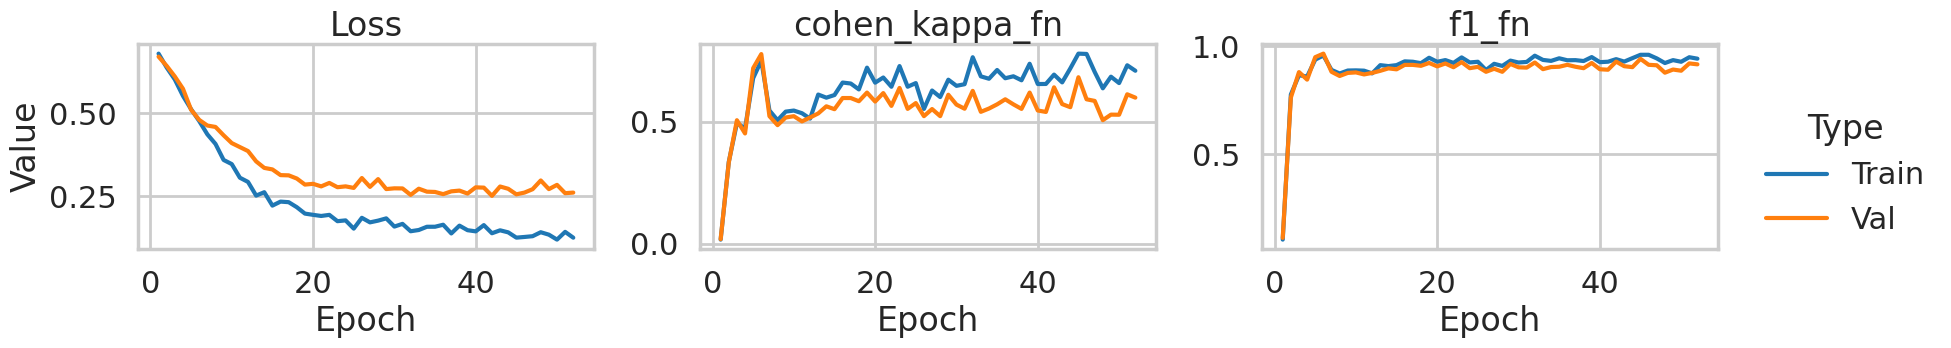

In [14]:
trainer_cnn_0.plot_epochs()

In [15]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2221 | Test cohen_kappa_fn: 0.6448 | Test f1_fn: 0.9251


#### Finetune

In [16]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config_fine,
    train_loader_len=len(train_loader),
    total_epochs=100,
)

trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [17]:
cnn_0.unfreeze_backbone()
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.1293 | Val Loss: 0.2555 | Train cohen_kappa_fn: 0.7164 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9459 | Val f1_fn: 0.9173
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.1475 | Val Loss: 0.2636 | Train cohen_kappa_fn: 0.7616 | Val cohen_kappa_fn: 0.5864 | Train f1_fn: 0.9544 | Val f1_fn: 0.9134
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.1200 | Val Loss: 0.2678 | Train cohen_kappa_fn: 0.6794 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.9340 | Val f1_fn: 0.8974
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.1216 | Val Loss: 0.2784 | Train cohen_kappa_fn: 0.6477 | Val cohen_kappa_fn: 0.5115 | Train f1_fn: 0.9247 | Val f1_fn: 0.8844
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.1300 | Val Loss: 0.2775 | Train cohen_kappa_fn: 0.6457 | Val cohen_kappa_fn: 0.5524 | Train f1_fn: 0.9227 | Val f1_fn: 0.8974
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.1167 | Val Loss: 0.2650 | Train cohen_kappa_fn: 0.7273 | Val cohen_kappa_fn: 0.5773 | Train f1_fn: 0.9463 | Val f1_fn: 0.9062
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.1217 | Val Loss: 0.2450 | Train cohen_kappa_fn: 0.7370 | Val cohen_kappa_fn: 0.6121 | Train f1_fn: 0.9488 | Val f1_fn: 0.9194
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.1100 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.7323 | Val cohen_kappa_fn: 0.6052 | Train f1_fn: 0.9480 | Val f1_fn: 0.9173
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1389 | Val Loss: 0.2496 | Train cohen_kappa_fn: 0.7483 | Val cohen_kappa_fn: 0.5837 | Train f1_fn: 0.9511 | Val f1_fn: 0.9084
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.1275 | Val Loss: 0.2357 | Train cohen_kappa_fn: 0.7928 | Val cohen_kappa_fn: 0.6479 | Train f1_fn: 0.9616 | Val f1_fn: 0.9300
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1122 | Val Loss: 0.2191 | Train cohen_kappa_fn: 0.8231 | Val cohen_kappa_fn: 0.7447 | Train f1_fn: 0.9698 | Val f1_fn: 0.9544
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.0905 | Val Loss: 0.2230 | Train cohen_kappa_fn: 0.8408 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9737 | Val f1_fn: 0.9645
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.1047 | Val Loss: 0.2039 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7870 | Train f1_fn: 0.9682 | Val f1_fn: 0.9644
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.0814 | Val Loss: 0.1911 | Train cohen_kappa_fn: 0.8427 | Val cohen_kappa_fn: 0.7782 | Train f1_fn: 0.9727 | Val f1_fn: 0.9600
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.0892 | Val Loss: 0.2381 | Train cohen_kappa_fn: 0.7684 | Val cohen_kappa_fn: 0.6102 | Train f1_fn: 0.9560 | Val f1_fn: 0.9170
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0940 | Val Loss: 0.2969 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.4662 | Train f1_fn: 0.9412 | Val f1_fn: 0.8517
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.0934 | Val Loss: 0.3342 | Train cohen_kappa_fn: 0.6059 | Val cohen_kappa_fn: 0.4614 | Train f1_fn: 0.9097 | Val f1_fn: 0.8493
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.0984 | Val Loss: 0.2239 | Train cohen_kappa_fn: 0.7904 | Val cohen_kappa_fn: 0.6828 | Train f1_fn: 0.9607 | Val f1_fn: 0.9380
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.0677 | Val Loss: 0.2435 | Train cohen_kappa_fn: 0.7497 | Val cohen_kappa_fn: 0.5837 | Train f1_fn: 0.9510 | Val f1_fn: 0.9084
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.0964 | Val Loss: 0.2704 | Train cohen_kappa_fn: 0.7023 | Val cohen_kappa_fn: 0.5621 | Train f1_fn: 0.9387 | Val f1_fn: 0.8939
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.0698 | Val Loss: 0.2123 | Train cohen_kappa_fn: 0.8331 | Val cohen_kappa_fn: 0.6751 | Train f1_fn: 0.9703 | Val f1_fn: 0.9359
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0861 | Val Loss: 0.1917 | Train cohen_kappa_fn: 0.8514 | Val cohen_kappa_fn: 0.7146 | Train f1_fn: 0.9742 | Val f1_fn: 0.9462
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.0701 | Val Loss: 0.1911 | Train cohen_kappa_fn: 0.9246 | Val cohen_kappa_fn: 0.8367 | Train f1_fn: 0.9881 | Val f1_fn: 0.9740
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.0555 | Val Loss: 0.1893 | Train cohen_kappa_fn: 0.8083 | Val cohen_kappa_fn: 0.6688 | Train f1_fn: 0.9647 | Val f1_fn: 0.9312
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.0605 | Val Loss: 0.2097 | Train cohen_kappa_fn: 0.8532 | Val cohen_kappa_fn: 0.6870 | Train f1_fn: 0.9742 | Val f1_fn: 0.9377
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.0554 | Val Loss: 0.2014 | Train cohen_kappa_fn: 0.8912 | Val cohen_kappa_fn: 0.7997 | Train f1_fn: 0.9820 | Val f1_fn: 0.9662
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.0469 | Val Loss: 0.1857 | Train cohen_kappa_fn: 0.9535 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9925 | Val f1_fn: 0.9681
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.0767 | Val Loss: 0.2204 | Train cohen_kappa_fn: 0.8379 | Val cohen_kappa_fn: 0.6943 | Train f1_fn: 0.9710 | Val f1_fn: 0.9423
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.0466 | Val Loss: 0.2268 | Train cohen_kappa_fn: 0.7663 | Val cohen_kappa_fn: 0.6261 | Train f1_fn: 0.9551 | Val f1_fn: 0.9237
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.0443 | Val Loss: 0.2373 | Train cohen_kappa_fn: 0.8083 | Val cohen_kappa_fn: 0.6219 | Train f1_fn: 0.9647 | Val f1_fn: 0.9188
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.0391 | Val Loss: 0.2123 | Train cohen_kappa_fn: 0.9393 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9903 | Val f1_fn: 0.9681
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.0596 | Val Loss: 0.2245 | Train cohen_kappa_fn: 0.9563 | Val cohen_kappa_fn: 0.8472 | Train f1_fn: 0.9933 | Val f1_fn: 0.9759
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.0518 | Val Loss: 0.2150 | Train cohen_kappa_fn: 0.9256 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9881 | Val f1_fn: 0.9701
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.0311 | Val Loss: 0.1565 | Train cohen_kappa_fn: 0.9714 | Val cohen_kappa_fn: 0.8418 | Train f1_fn: 0.9955 | Val f1_fn: 0.9738
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.0384 | Val Loss: 0.1649 | Train cohen_kappa_fn: 0.9577 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9933 | Val f1_fn: 0.9701
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.0335 | Val Loss: 0.1769 | Train cohen_kappa_fn: 0.9532 | Val cohen_kappa_fn: 0.8033 | Train f1_fn: 0.9925 | Val f1_fn: 0.9683
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.0311 | Val Loss: 0.1804 | Train cohen_kappa_fn: 0.9669 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9948 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.0216 | Val Loss: 0.1709 | Train cohen_kappa_fn: 0.9270 | Val cohen_kappa_fn: 0.7571 | Train f1_fn: 0.9880 | Val f1_fn: 0.9562
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.0201 | Val Loss: 0.2234 | Train cohen_kappa_fn: 0.8891 | Val cohen_kappa_fn: 0.7024 | Train f1_fn: 0.9811 | Val f1_fn: 0.9443
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.0380 | Val Loss: 0.2071 | Train cohen_kappa_fn: 0.9099 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9850 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.0435 | Val Loss: 0.2280 | Train cohen_kappa_fn: 0.9265 | Val cohen_kappa_fn: 0.7808 | Train f1_fn: 0.9880 | Val f1_fn: 0.9623
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.0255 | Val Loss: 0.2346 | Train cohen_kappa_fn: 0.9575 | Val cohen_kappa_fn: 0.7775 | Train f1_fn: 0.9933 | Val f1_fn: 0.9624
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.0305 | Val Loss: 0.1879 | Train cohen_kappa_fn: 0.9397 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9903 | Val f1_fn: 0.9522
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.0335 | Val Loss: 0.2066 | Train cohen_kappa_fn: 0.8809 | Val cohen_kappa_fn: 0.6453 | Train f1_fn: 0.9796 | Val f1_fn: 0.9276
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


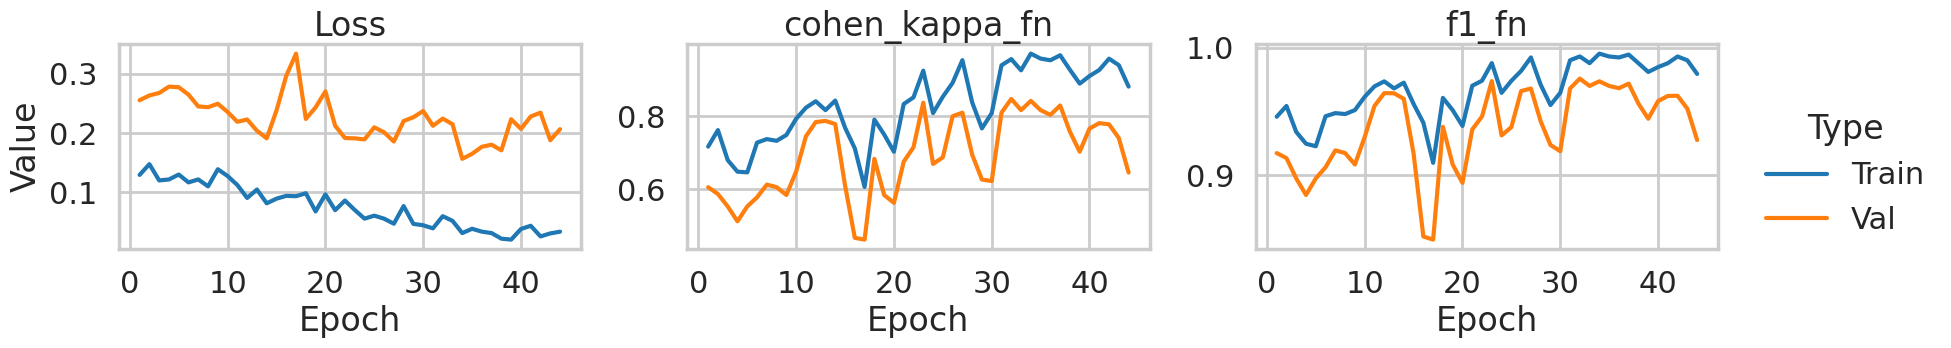

In [18]:
trainer_cnn_0.plot_epochs()

In [19]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1101 | Test cohen_kappa_fn: 0.8517 | Test f1_fn: 0.9749


#### Visualization

In [20]:
visualizer_0 = Visualizer(model=trainer_cnn_0.model, device=device, labels_map=labels_map)

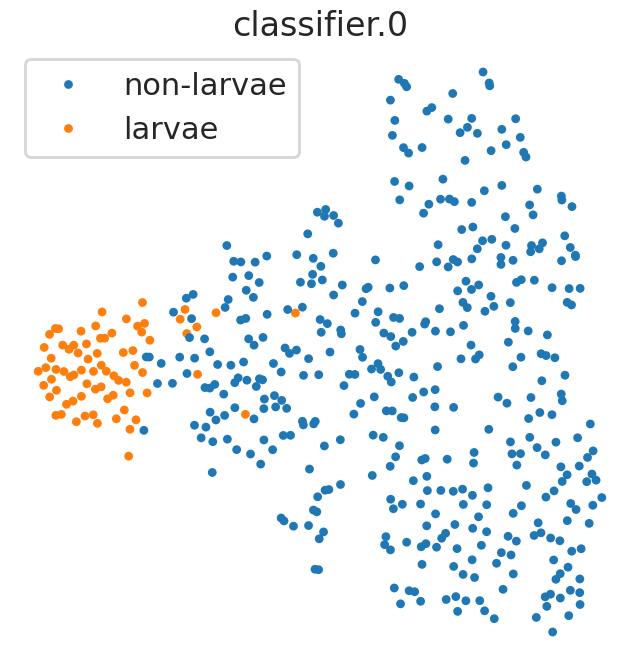

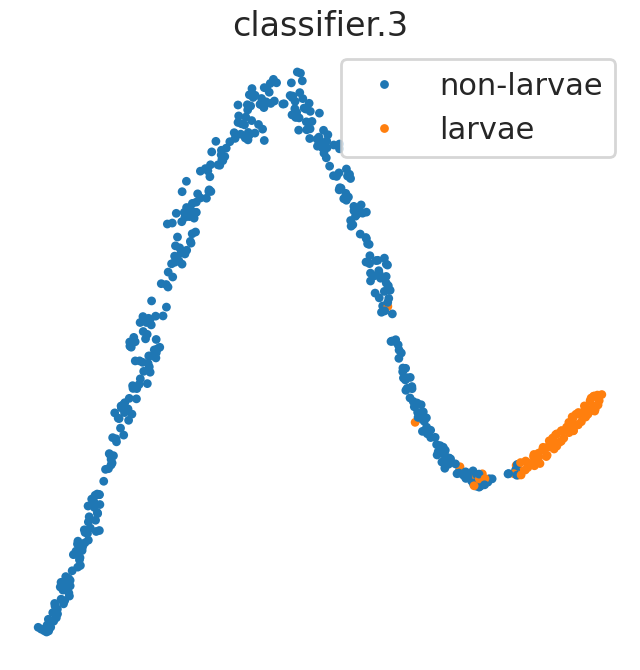

In [21]:
# Display layer representations
visualizer_0.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


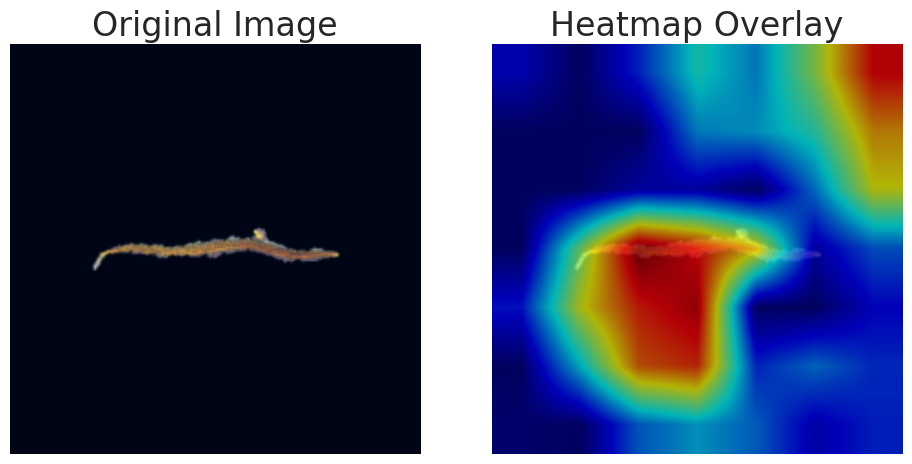

  Generating heatmap for Larvae...
  Predicted label is Larvae!


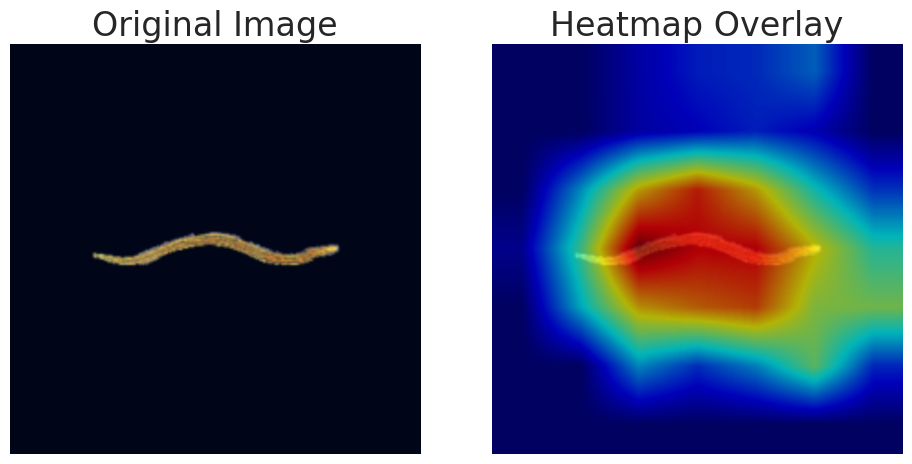

In [22]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_0.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.3. CNN1

In [23]:
cnn_1 = PretrainedCNNClassifier(
    num_classes=num_classes,
    backbone="squeezenet1_0",
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [24]:
ckpt_cnn_1 = "weights/larvae-pre-cnn-1.pt"

#### Train MLP

In [25]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config_mlp,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [26]:
cnn_1.freeze_backbone()
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6401 | Val Loss: 0.5318 | Train cohen_kappa_fn: 0.4721 | Val cohen_kappa_fn: 0.4676 | Train f1_fn: 0.8624 | Val f1_fn: 0.8876
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.4971 | Val Loss: 0.4255 | Train cohen_kappa_fn: 0.5893 | Val cohen_kappa_fn: 0.6381 | Train f1_fn: 0.9056 | Val f1_fn: 0.9255
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.3932 | Val Loss: 0.3539 | Train cohen_kappa_fn: 0.6467 | Val cohen_kappa_fn: 0.6479 | Train f1_fn: 0.9237 | Val f1_fn: 0.9300
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.3240 | Val Loss: 0.3051 | Train cohen_kappa_fn: 0.6601 | Val cohen_kappa_fn: 0.6600 | Train f1_fn: 0.9290 | Val f1_fn: 0.9318
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.2865 | Val Loss: 0.2746 | Train cohen_kappa_fn: 0.7194 | Val cohen_kappa_fn: 0.7149 | Train f1_fn: 0.9447 | Val f1_fn: 0.9486
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.2474 | Val Loss: 0.2533 | Train cohen_kappa_fn: 0.7493 | Val cohen_kappa_fn: 0.7589 | Train f1_fn: 0.9530 | Val f1_fn: 0.9585
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.2227 | Val Loss: 0.2396 | Train cohen_kappa_fn: 0.7741 | Val cohen_kappa_fn: 0.7934 | Train f1_fn: 0.9605 | Val f1_fn: 0.9664
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.2130 | Val Loss: 0.2233 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9682 | Val f1_fn: 0.9645
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.1971 | Val Loss: 0.2169 | Train cohen_kappa_fn: 0.7830 | Val cohen_kappa_fn: 0.7870 | Train f1_fn: 0.9611 | Val f1_fn: 0.9644
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.1900 | Val Loss: 0.2122 | Train cohen_kappa_fn: 0.7771 | Val cohen_kappa_fn: 0.7681 | Train f1_fn: 0.9594 | Val f1_fn: 0.9605
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.1843 | Val Loss: 0.1996 | Train cohen_kappa_fn: 0.7745 | Val cohen_kappa_fn: 0.7966 | Train f1_fn: 0.9596 | Val f1_fn: 0.9663
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.1698 | Val Loss: 0.1975 | Train cohen_kappa_fn: 0.7965 | Val cohen_kappa_fn: 0.7966 | Train f1_fn: 0.9643 | Val f1_fn: 0.9663
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.1718 | Val Loss: 0.1946 | Train cohen_kappa_fn: 0.8014 | Val cohen_kappa_fn: 0.7966 | Train f1_fn: 0.9650 | Val f1_fn: 0.9663
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.1554 | Val Loss: 0.1929 | Train cohen_kappa_fn: 0.8142 | Val cohen_kappa_fn: 0.7934 | Train f1_fn: 0.9683 | Val f1_fn: 0.9664
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.1562 | Val Loss: 0.1969 | Train cohen_kappa_fn: 0.8338 | Val cohen_kappa_fn: 0.8134 | Train f1_fn: 0.9722 | Val f1_fn: 0.9703
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1496 | Val Loss: 0.1864 | Train cohen_kappa_fn: 0.8192 | Val cohen_kappa_fn: 0.8033 | Train f1_fn: 0.9690 | Val f1_fn: 0.9683
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.1394 | Val Loss: 0.1786 | Train cohen_kappa_fn: 0.7891 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9627 | Val f1_fn: 0.9700
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1454 | Val Loss: 0.1774 | Train cohen_kappa_fn: 0.7891 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9627 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.1361 | Val Loss: 0.1717 | Train cohen_kappa_fn: 0.7977 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9643 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.1392 | Val Loss: 0.1658 | Train cohen_kappa_fn: 0.7843 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9610 | Val f1_fn: 0.9681
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.1356 | Val Loss: 0.1676 | Train cohen_kappa_fn: 0.8089 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9666 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1351 | Val Loss: 0.1695 | Train cohen_kappa_fn: 0.8338 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9722 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1234 | Val Loss: 0.1641 | Train cohen_kappa_fn: 0.8417 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9728 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1281 | Val Loss: 0.1636 | Train cohen_kappa_fn: 0.8165 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9682 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.1223 | Val Loss: 0.1682 | Train cohen_kappa_fn: 0.8505 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9743 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1105 | Val Loss: 0.1558 | Train cohen_kappa_fn: 0.8301 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9704 | Val f1_fn: 0.9739
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.1163 | Val Loss: 0.1564 | Train cohen_kappa_fn: 0.8496 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9743 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.1131 | Val Loss: 0.1601 | Train cohen_kappa_fn: 0.8599 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9767 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1018 | Val Loss: 0.1547 | Train cohen_kappa_fn: 0.8418 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9737 | Val f1_fn: 0.9777
  🔥 New best model saved!


📘 Epoch 30 | Train Loss: 0.1060 | Val Loss: 0.1462 | Train cohen_kappa_fn: 0.8625 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9766 | Val f1_fn: 0.9758
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.1026 | Val Loss: 0.1465 | Train cohen_kappa_fn: 0.8648 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9774 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.0998 | Val Loss: 0.1513 | Train cohen_kappa_fn: 0.8730 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9790 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1120 | Val Loss: 0.1389 | Train cohen_kappa_fn: 0.8349 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9712 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.0971 | Val Loss: 0.1422 | Train cohen_kappa_fn: 0.8657 | Val cohen_kappa_fn: 0.8393 | Train f1_fn: 0.9774 | Val f1_fn: 0.9739
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.0969 | Val Loss: 0.1422 | Train cohen_kappa_fn: 0.8648 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9774 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1148 | Val Loss: 0.1380 | Train cohen_kappa_fn: 0.8545 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9751 | Val f1_fn: 0.9720
  🔥 New best model saved!


📘 Epoch 37 | Train Loss: 0.0892 | Val Loss: 0.1330 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.8344 | Train f1_fn: 0.9719 | Val f1_fn: 0.9718
  🔥 New best model saved!


📘 Epoch 38 | Train Loss: 0.1022 | Val Loss: 0.1410 | Train cohen_kappa_fn: 0.8856 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9813 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.0912 | Val Loss: 0.1397 | Train cohen_kappa_fn: 0.8905 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9820 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.0849 | Val Loss: 0.1364 | Train cohen_kappa_fn: 0.8730 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9790 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.0905 | Val Loss: 0.1341 | Train cohen_kappa_fn: 0.8795 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9797 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.0885 | Val Loss: 0.1279 | Train cohen_kappa_fn: 0.8780 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9797 | Val f1_fn: 0.9777
  🔥 New best model saved!


📘 Epoch 43 | Train Loss: 0.0779 | Val Loss: 0.1326 | Train cohen_kappa_fn: 0.8828 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9805 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 44 | Train Loss: 0.0793 | Val Loss: 0.1316 | Train cohen_kappa_fn: 0.8730 | Val cohen_kappa_fn: 0.8707 | Train f1_fn: 0.9790 | Val f1_fn: 0.9796
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.0843 | Val Loss: 0.1336 | Train cohen_kappa_fn: 0.8905 | Val cohen_kappa_fn: 0.8707 | Train f1_fn: 0.9820 | Val f1_fn: 0.9796
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.0905 | Val Loss: 0.1227 | Train cohen_kappa_fn: 0.8705 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9781 | Val f1_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 47 | Train Loss: 0.0802 | Val Loss: 0.1223 | Train cohen_kappa_fn: 0.8795 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9797 | Val f1_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 48 | Train Loss: 0.0911 | Val Loss: 0.1283 | Train cohen_kappa_fn: 0.8863 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9812 | Val f1_fn: 0.9814
  ❄️ No improvement, model won't be saved!


📘 Epoch 49 | Train Loss: 0.0863 | Val Loss: 0.1267 | Train cohen_kappa_fn: 0.8912 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9820 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 50 | Train Loss: 0.0756 | Val Loss: 0.1200 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9835 | Val f1_fn: 0.9832
  🔥 New best model saved!


📘 Epoch 51 | Train Loss: 0.0747 | Val Loss: 0.1244 | Train cohen_kappa_fn: 0.9033 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9843 | Val f1_fn: 0.9814
  ❄️ No improvement, model won't be saved!


📘 Epoch 52 | Train Loss: 0.0639 | Val Loss: 0.1265 | Train cohen_kappa_fn: 0.9119 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9858 | Val f1_fn: 0.9814
  ❄️ No improvement, model won't be saved!


📘 Epoch 53 | Train Loss: 0.0803 | Val Loss: 0.1189 | Train cohen_kappa_fn: 0.8954 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9827 | Val f1_fn: 0.9832
  🔥 New best model saved!


📘 Epoch 54 | Train Loss: 0.0741 | Val Loss: 0.1130 | Train cohen_kappa_fn: 0.8905 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9820 | Val f1_fn: 0.9832
  🔥 New best model saved!


📘 Epoch 55 | Train Loss: 0.0714 | Val Loss: 0.1159 | Train cohen_kappa_fn: 0.8954 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9827 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 56 | Train Loss: 0.0693 | Val Loss: 0.1196 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9842 | Val f1_fn: 0.9814
  ❄️ No improvement, model won't be saved!


📘 Epoch 57 | Train Loss: 0.0722 | Val Loss: 0.1306 | Train cohen_kappa_fn: 0.9256 | Val cohen_kappa_fn: 0.8942 | Train f1_fn: 0.9881 | Val f1_fn: 0.9833
  ❄️ No improvement, model won't be saved!


📘 Epoch 58 | Train Loss: 0.0752 | Val Loss: 0.1281 | Train cohen_kappa_fn: 0.9119 | Val cohen_kappa_fn: 0.8942 | Train f1_fn: 0.9858 | Val f1_fn: 0.9833
  ❄️ No improvement, model won't be saved!


📘 Epoch 59 | Train Loss: 0.0662 | Val Loss: 0.1175 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9835 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 60 | Train Loss: 0.0650 | Val Loss: 0.1190 | Train cohen_kappa_fn: 0.8947 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9828 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 61 | Train Loss: 0.0760 | Val Loss: 0.1221 | Train cohen_kappa_fn: 0.9261 | Val cohen_kappa_fn: 0.8942 | Train f1_fn: 0.9880 | Val f1_fn: 0.9833
  ❄️ No improvement, model won't be saved!


📘 Epoch 62 | Train Loss: 0.0658 | Val Loss: 0.1098 | Train cohen_kappa_fn: 0.8967 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9827 | Val f1_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 63 | Train Loss: 0.0685 | Val Loss: 0.1058 | Train cohen_kappa_fn: 0.8960 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9827 | Val f1_fn: 0.9813
  🔥 New best model saved!


📘 Epoch 64 | Train Loss: 0.0574 | Val Loss: 0.1075 | Train cohen_kappa_fn: 0.9353 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9895 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 65 | Train Loss: 0.0726 | Val Loss: 0.1143 | Train cohen_kappa_fn: 0.9136 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9857 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 66 | Train Loss: 0.0605 | Val Loss: 0.1136 | Train cohen_kappa_fn: 0.8828 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9805 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 67 | Train Loss: 0.0651 | Val Loss: 0.1124 | Train cohen_kappa_fn: 0.8821 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9805 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 68 | Train Loss: 0.0631 | Val Loss: 0.1093 | Train cohen_kappa_fn: 0.9082 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9850 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 69 | Train Loss: 0.0718 | Val Loss: 0.1092 | Train cohen_kappa_fn: 0.9093 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9850 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 70 | Train Loss: 0.0629 | Val Loss: 0.1133 | Train cohen_kappa_fn: 0.9261 | Val cohen_kappa_fn: 0.9177 | Train f1_fn: 0.9880 | Val f1_fn: 0.9870
  ❄️ No improvement, model won't be saved!


📘 Epoch 71 | Train Loss: 0.0680 | Val Loss: 0.1147 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.9177 | Train f1_fn: 0.9842 | Val f1_fn: 0.9870
  ❄️ No improvement, model won't be saved!


📘 Epoch 72 | Train Loss: 0.0598 | Val Loss: 0.1083 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.9067 | Train f1_fn: 0.9842 | Val f1_fn: 0.9851
  ❄️ No improvement, model won't be saved!


📘 Epoch 73 | Train Loss: 0.0585 | Val Loss: 0.1139 | Train cohen_kappa_fn: 0.9227 | Val cohen_kappa_fn: 0.9177 | Train f1_fn: 0.9872 | Val f1_fn: 0.9870
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


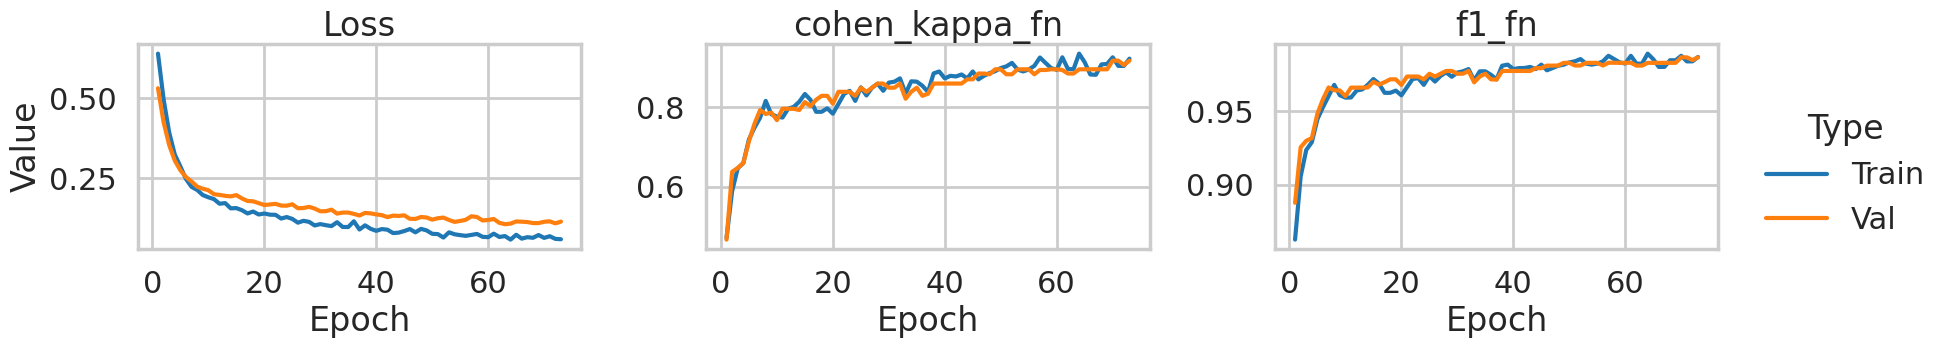

In [27]:
trainer_cnn_1.plot_epochs()

In [28]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.0772 | Test cohen_kappa_fn: 0.8951 | Test f1_fn: 0.9825


#### Finetune

In [29]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config_fine,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [30]:
cnn_1.unfreeze_backbone()
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.0628 | Val Loss: 0.1206 | Train cohen_kappa_fn: 0.9202 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9873 | Val f1_fn: 0.9814
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.0698 | Val Loss: 0.1028 | Train cohen_kappa_fn: 0.9045 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9842 | Val f1_fn: 0.9832
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.0537 | Val Loss: 0.1039 | Train cohen_kappa_fn: 0.9179 | Val cohen_kappa_fn: 0.9096 | Train f1_fn: 0.9865 | Val f1_fn: 0.9850
  ❄️ No improvement, model won't be saved!


📘 Epoch 4 | Train Loss: 0.0517 | Val Loss: 0.1245 | Train cohen_kappa_fn: 0.9389 | Val cohen_kappa_fn: 0.9052 | Train f1_fn: 0.9903 | Val f1_fn: 0.9852
  ❄️ No improvement, model won't be saved!


📘 Epoch 5 | Train Loss: 0.0532 | Val Loss: 0.1341 | Train cohen_kappa_fn: 0.9389 | Val cohen_kappa_fn: 0.9052 | Train f1_fn: 0.9903 | Val f1_fn: 0.9852
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.0554 | Val Loss: 0.1116 | Train cohen_kappa_fn: 0.9265 | Val cohen_kappa_fn: 0.8959 | Train f1_fn: 0.9880 | Val f1_fn: 0.9832
  ❄️ No improvement, model won't be saved!


📘 Epoch 7 | Train Loss: 0.0524 | Val Loss: 0.1165 | Train cohen_kappa_fn: 0.9227 | Val cohen_kappa_fn: 0.8870 | Train f1_fn: 0.9872 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 8 | Train Loss: 0.0403 | Val Loss: 0.1184 | Train cohen_kappa_fn: 0.9401 | Val cohen_kappa_fn: 0.9177 | Train f1_fn: 0.9903 | Val f1_fn: 0.9870
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.0354 | Val Loss: 0.1516 | Train cohen_kappa_fn: 0.9667 | Val cohen_kappa_fn: 0.9052 | Train f1_fn: 0.9948 | Val f1_fn: 0.9852
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.0404 | Val Loss: 0.1269 | Train cohen_kappa_fn: 0.9577 | Val cohen_kappa_fn: 0.9067 | Train f1_fn: 0.9933 | Val f1_fn: 0.9851
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.0322 | Val Loss: 0.1180 | Train cohen_kappa_fn: 0.9535 | Val cohen_kappa_fn: 0.8852 | Train f1_fn: 0.9925 | Val f1_fn: 0.9813
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.0271 | Val Loss: 0.1447 | Train cohen_kappa_fn: 0.9669 | Val cohen_kappa_fn: 0.9052 | Train f1_fn: 0.9948 | Val f1_fn: 0.9852
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


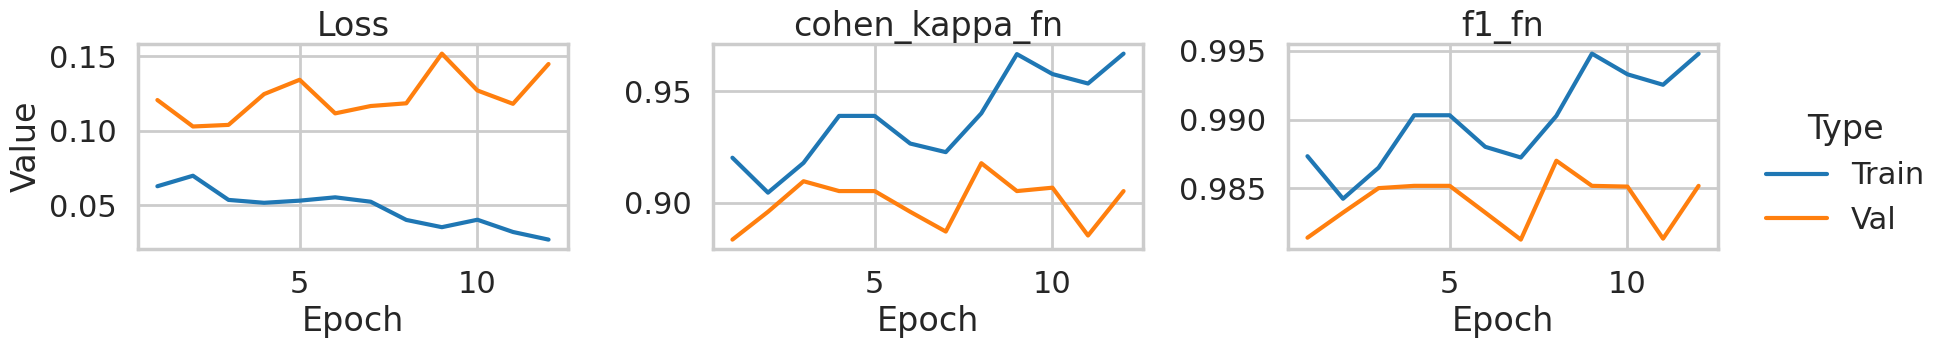

In [31]:
trainer_cnn_1.plot_epochs()

In [32]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.0716 | Test cohen_kappa_fn: 0.9154 | Test f1_fn: 0.9863


#### Visualization

In [33]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

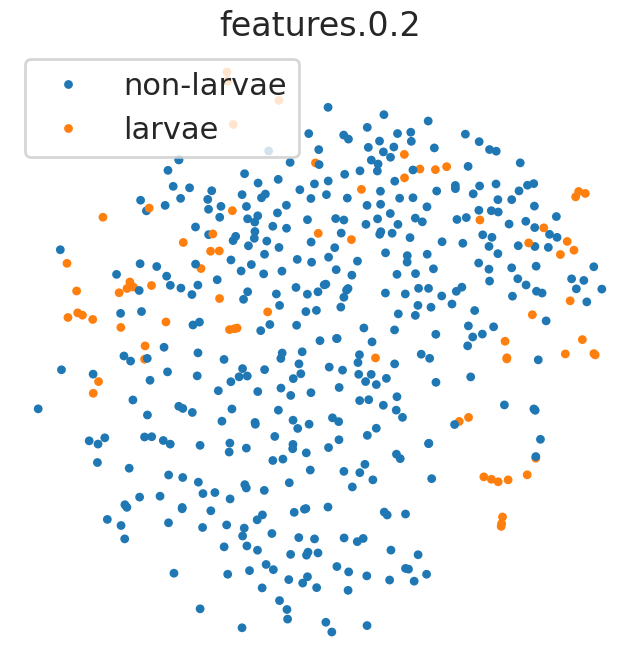

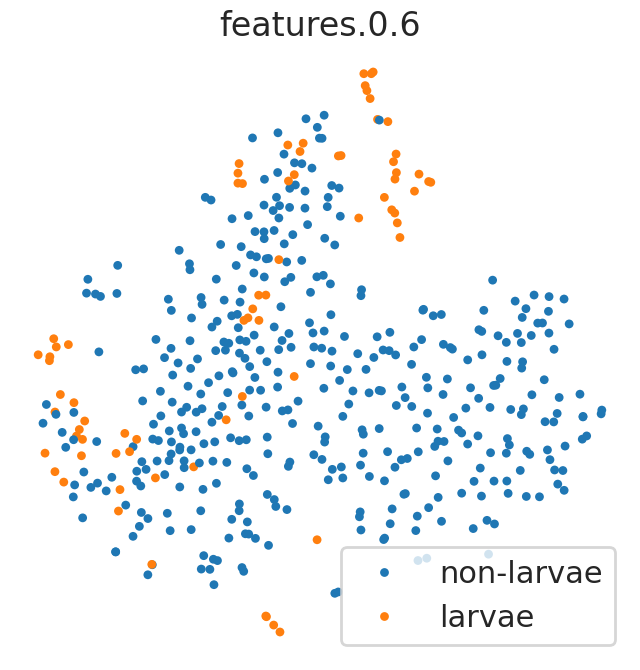

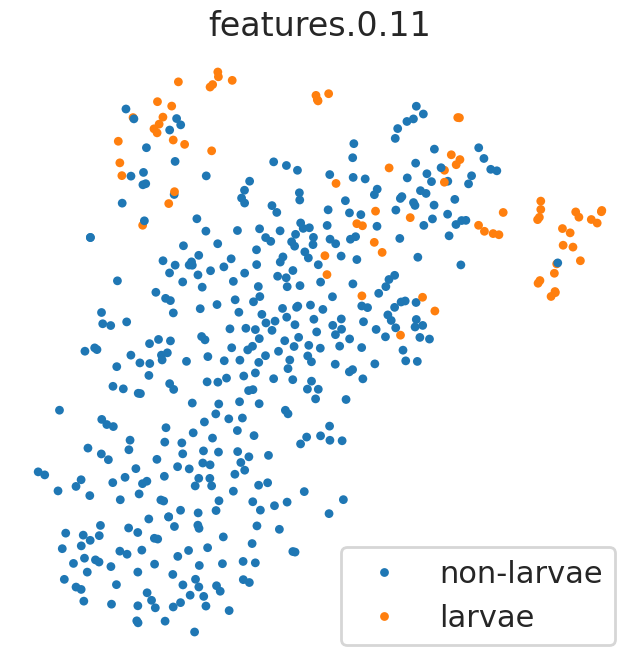

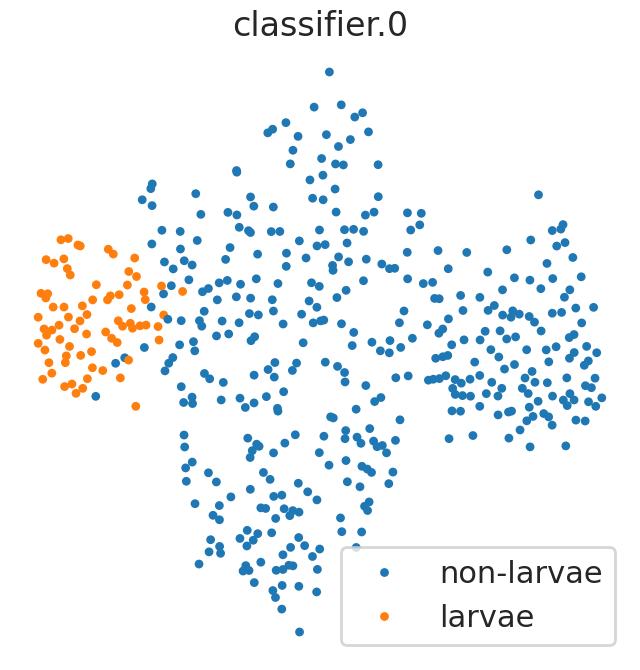

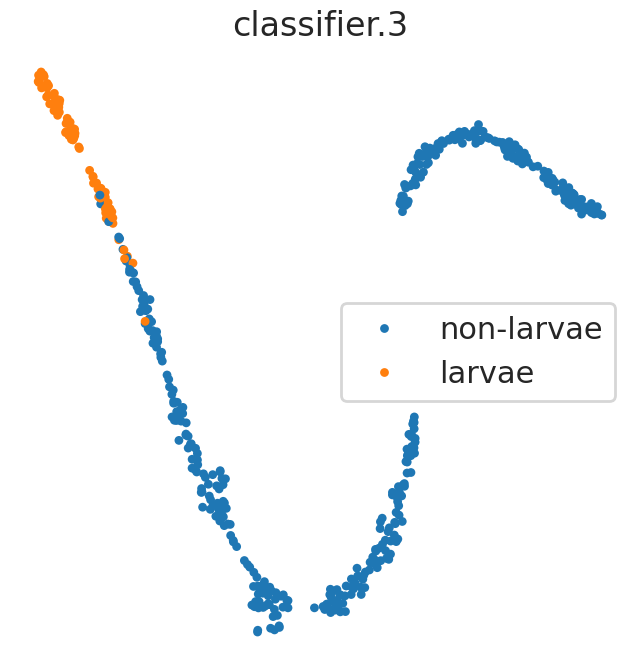

In [34]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


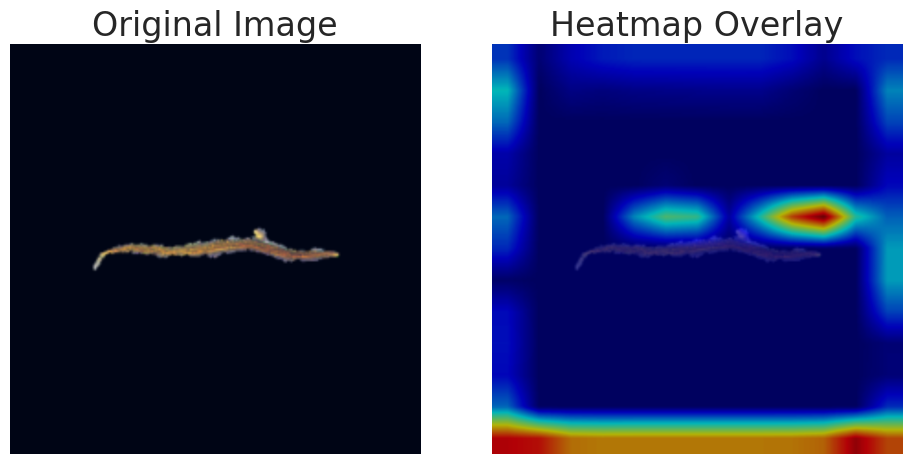

  Generating heatmap for Larvae...
  Predicted label is Larvae!


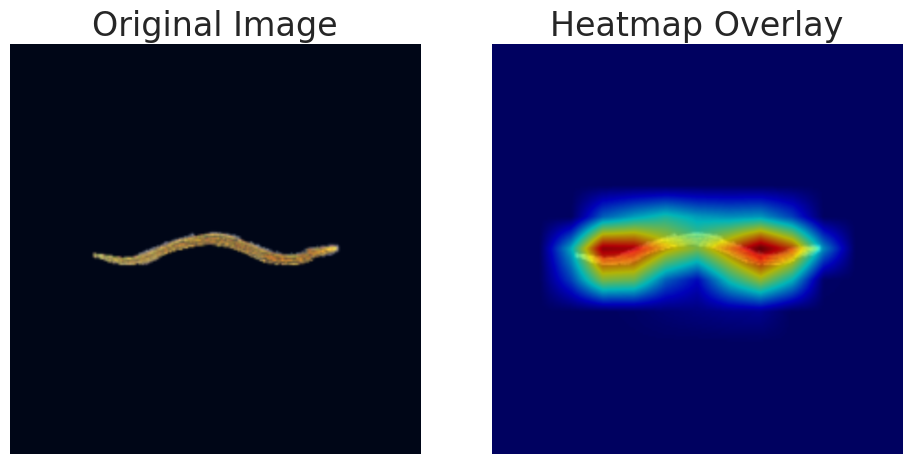

In [35]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

### 3.4. CNN2

In [36]:
cnn_2 = PretrainedCNNClassifier(
    num_classes=num_classes,
    backbone="resnet18",
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [37]:
ckpt_cnn_2 = "weights/larvae-pre-cnn-2.pt"

#### Train MLP

In [38]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config_mlp,
    train_loader_len=len(train_loader),
    total_epochs=100,
)

trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [39]:
cnn_2.freeze_backbone()
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.7082 | Val Loss: 0.6778 | Train cohen_kappa_fn: 0.1528 | Val cohen_kappa_fn: 0.0932 | Train f1_fn: 0.5762 | Val f1_fn: 0.5187
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6324 | Val Loss: 0.6081 | Train cohen_kappa_fn: 0.4477 | Val cohen_kappa_fn: 0.3879 | Train f1_fn: 0.8701 | Val f1_fn: 0.8337
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5744 | Val Loss: 0.5563 | Train cohen_kappa_fn: 0.4770 | Val cohen_kappa_fn: 0.4233 | Train f1_fn: 0.8607 | Val f1_fn: 0.8326
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.5202 | Val Loss: 0.5119 | Train cohen_kappa_fn: 0.5438 | Val cohen_kappa_fn: 0.4369 | Train f1_fn: 0.8896 | Val f1_fn: 0.8401
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.4828 | Val Loss: 0.4609 | Train cohen_kappa_fn: 0.6227 | Val cohen_kappa_fn: 0.5593 | Train f1_fn: 0.9190 | Val f1_fn: 0.9022
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.4399 | Val Loss: 0.4230 | Train cohen_kappa_fn: 0.6720 | Val cohen_kappa_fn: 0.6406 | Train f1_fn: 0.9354 | Val f1_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4041 | Val Loss: 0.3958 | Train cohen_kappa_fn: 0.6915 | Val cohen_kappa_fn: 0.7189 | Train f1_fn: 0.9433 | Val f1_fn: 0.9484
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.3718 | Val Loss: 0.3681 | Train cohen_kappa_fn: 0.7214 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9476 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.3483 | Val Loss: 0.3431 | Train cohen_kappa_fn: 0.6830 | Val cohen_kappa_fn: 0.6406 | Train f1_fn: 0.9378 | Val f1_fn: 0.9279
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.3183 | Val Loss: 0.3206 | Train cohen_kappa_fn: 0.7228 | Val cohen_kappa_fn: 0.6706 | Train f1_fn: 0.9466 | Val f1_fn: 0.9362
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.2970 | Val Loss: 0.2997 | Train cohen_kappa_fn: 0.7148 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9460 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.2691 | Val Loss: 0.2936 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.6863 | Train f1_fn: 0.9442 | Val f1_fn: 0.9403
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.2655 | Val Loss: 0.2841 | Train cohen_kappa_fn: 0.7336 | Val cohen_kappa_fn: 0.7360 | Train f1_fn: 0.9519 | Val f1_fn: 0.9524
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2593 | Val Loss: 0.2657 | Train cohen_kappa_fn: 0.6928 | Val cohen_kappa_fn: 0.6751 | Train f1_fn: 0.9382 | Val f1_fn: 0.9359
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.2323 | Val Loss: 0.2610 | Train cohen_kappa_fn: 0.7179 | Val cohen_kappa_fn: 0.6906 | Train f1_fn: 0.9448 | Val f1_fn: 0.9400
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2409 | Val Loss: 0.2581 | Train cohen_kappa_fn: 0.7445 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9523 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.2349 | Val Loss: 0.2486 | Train cohen_kappa_fn: 0.7341 | Val cohen_kappa_fn: 0.7146 | Train f1_fn: 0.9489 | Val f1_fn: 0.9462
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2105 | Val Loss: 0.2418 | Train cohen_kappa_fn: 0.7527 | Val cohen_kappa_fn: 0.7398 | Train f1_fn: 0.9538 | Val f1_fn: 0.9522
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2064 | Val Loss: 0.2484 | Train cohen_kappa_fn: 0.7854 | Val cohen_kappa_fn: 0.7535 | Train f1_fn: 0.9619 | Val f1_fn: 0.9564
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1896 | Val Loss: 0.2280 | Train cohen_kappa_fn: 0.7164 | Val cohen_kappa_fn: 0.7268 | Train f1_fn: 0.9459 | Val f1_fn: 0.9480
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2011 | Val Loss: 0.2340 | Train cohen_kappa_fn: 0.7278 | Val cohen_kappa_fn: 0.7606 | Train f1_fn: 0.9483 | Val f1_fn: 0.9560
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1961 | Val Loss: 0.2468 | Train cohen_kappa_fn: 0.7953 | Val cohen_kappa_fn: 0.7836 | Train f1_fn: 0.9662 | Val f1_fn: 0.9645
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.1955 | Val Loss: 0.2214 | Train cohen_kappa_fn: 0.7988 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9632 | Val f1_fn: 0.9520
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1797 | Val Loss: 0.2237 | Train cohen_kappa_fn: 0.7430 | Val cohen_kappa_fn: 0.7606 | Train f1_fn: 0.9524 | Val f1_fn: 0.9560
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1795 | Val Loss: 0.2221 | Train cohen_kappa_fn: 0.8111 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9665 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1778 | Val Loss: 0.2211 | Train cohen_kappa_fn: 0.7952 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9644 | Val f1_fn: 0.9602
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.1721 | Val Loss: 0.2173 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9533 | Val f1_fn: 0.9602
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.1699 | Val Loss: 0.2050 | Train cohen_kappa_fn: 0.7275 | Val cohen_kappa_fn: 0.7268 | Train f1_fn: 0.9473 | Val f1_fn: 0.9480
  🔥 New best model saved!


📘 Epoch 29 | Train Loss: 0.1518 | Val Loss: 0.2222 | Train cohen_kappa_fn: 0.8457 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9735 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1781 | Val Loss: 0.2077 | Train cohen_kappa_fn: 0.8051 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9658 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1505 | Val Loss: 0.1995 | Train cohen_kappa_fn: 0.8119 | Val cohen_kappa_fn: 0.7519 | Train f1_fn: 0.9655 | Val f1_fn: 0.9540
  🔥 New best model saved!


📘 Epoch 32 | Train Loss: 0.1444 | Val Loss: 0.2082 | Train cohen_kappa_fn: 0.8037 | Val cohen_kappa_fn: 0.7660 | Train f1_fn: 0.9649 | Val f1_fn: 0.9582
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1594 | Val Loss: 0.1976 | Train cohen_kappa_fn: 0.7891 | Val cohen_kappa_fn: 0.7484 | Train f1_fn: 0.9618 | Val f1_fn: 0.9542
  🔥 New best model saved!


📘 Epoch 34 | Train Loss: 0.1404 | Val Loss: 0.2028 | Train cohen_kappa_fn: 0.8115 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9674 | Val f1_fn: 0.9641
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1507 | Val Loss: 0.1899 | Train cohen_kappa_fn: 0.7740 | Val cohen_kappa_fn: 0.7519 | Train f1_fn: 0.9577 | Val f1_fn: 0.9540
  🔥 New best model saved!


📘 Epoch 36 | Train Loss: 0.1613 | Val Loss: 0.2027 | Train cohen_kappa_fn: 0.7977 | Val cohen_kappa_fn: 0.7997 | Train f1_fn: 0.9643 | Val f1_fn: 0.9662
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1456 | Val Loss: 0.1923 | Train cohen_kappa_fn: 0.7832 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9601 | Val f1_fn: 0.9602
  ❄️ No improvement, model won't be saved!


📘 Epoch 38 | Train Loss: 0.1549 | Val Loss: 0.2020 | Train cohen_kappa_fn: 0.8455 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9726 | Val f1_fn: 0.9681
  ❄️ No improvement, model won't be saved!


📘 Epoch 39 | Train Loss: 0.1362 | Val Loss: 0.1934 | Train cohen_kappa_fn: 0.8368 | Val cohen_kappa_fn: 0.8094 | Train f1_fn: 0.9720 | Val f1_fn: 0.9681
  ❄️ No improvement, model won't be saved!


📘 Epoch 40 | Train Loss: 0.1436 | Val Loss: 0.1901 | Train cohen_kappa_fn: 0.8273 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9696 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 41 | Train Loss: 0.1305 | Val Loss: 0.2007 | Train cohen_kappa_fn: 0.8633 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9766 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 42 | Train Loss: 0.1325 | Val Loss: 0.2022 | Train cohen_kappa_fn: 0.8319 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9713 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 43 | Train Loss: 0.1277 | Val Loss: 0.1848 | Train cohen_kappa_fn: 0.8263 | Val cohen_kappa_fn: 0.8220 | Train f1_fn: 0.9697 | Val f1_fn: 0.9699
  🔥 New best model saved!


📘 Epoch 44 | Train Loss: 0.1561 | Val Loss: 0.1952 | Train cohen_kappa_fn: 0.8554 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9750 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 45 | Train Loss: 0.1224 | Val Loss: 0.1889 | Train cohen_kappa_fn: 0.8203 | Val cohen_kappa_fn: 0.8027 | Train f1_fn: 0.9690 | Val f1_fn: 0.9660
  ❄️ No improvement, model won't be saved!


📘 Epoch 46 | Train Loss: 0.1376 | Val Loss: 0.1992 | Train cohen_kappa_fn: 0.8388 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9729 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 47 | Train Loss: 0.1193 | Val Loss: 0.1929 | Train cohen_kappa_fn: 0.8466 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9735 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 48 | Train Loss: 0.1247 | Val Loss: 0.2023 | Train cohen_kappa_fn: 0.8487 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9744 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 49 | Train Loss: 0.1116 | Val Loss: 0.1904 | Train cohen_kappa_fn: 0.8339 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9712 | Val f1_fn: 0.9641
  ❄️ No improvement, model won't be saved!


📘 Epoch 50 | Train Loss: 0.1388 | Val Loss: 0.1966 | Train cohen_kappa_fn: 0.8214 | Val cohen_kappa_fn: 0.8027 | Train f1_fn: 0.9689 | Val f1_fn: 0.9660
  ❄️ No improvement, model won't be saved!


📘 Epoch 51 | Train Loss: 0.1252 | Val Loss: 0.2065 | Train cohen_kappa_fn: 0.8754 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9789 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 52 | Train Loss: 0.1272 | Val Loss: 0.1838 | Train cohen_kappa_fn: 0.8208 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9680 | Val f1_fn: 0.9641
  🔥 New best model saved!


📘 Epoch 53 | Train Loss: 0.1298 | Val Loss: 0.1973 | Train cohen_kappa_fn: 0.8607 | Val cohen_kappa_fn: 0.8318 | Train f1_fn: 0.9767 | Val f1_fn: 0.9719
  ❄️ No improvement, model won't be saved!


📘 Epoch 54 | Train Loss: 0.1169 | Val Loss: 0.2014 | Train cohen_kappa_fn: 0.8378 | Val cohen_kappa_fn: 0.8318 | Train f1_fn: 0.9720 | Val f1_fn: 0.9719
  ❄️ No improvement, model won't be saved!


📘 Epoch 55 | Train Loss: 0.1336 | Val Loss: 0.1822 | Train cohen_kappa_fn: 0.8505 | Val cohen_kappa_fn: 0.8027 | Train f1_fn: 0.9743 | Val f1_fn: 0.9660
  🔥 New best model saved!


📘 Epoch 56 | Train Loss: 0.1287 | Val Loss: 0.2053 | Train cohen_kappa_fn: 0.8378 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9720 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 57 | Train Loss: 0.1145 | Val Loss: 0.1886 | Train cohen_kappa_fn: 0.8074 | Val cohen_kappa_fn: 0.8318 | Train f1_fn: 0.9657 | Val f1_fn: 0.9719
  ❄️ No improvement, model won't be saved!


📘 Epoch 58 | Train Loss: 0.1179 | Val Loss: 0.1911 | Train cohen_kappa_fn: 0.8466 | Val cohen_kappa_fn: 0.8318 | Train f1_fn: 0.9735 | Val f1_fn: 0.9719
  ❄️ No improvement, model won't be saved!


📘 Epoch 59 | Train Loss: 0.1315 | Val Loss: 0.2099 | Train cohen_kappa_fn: 0.8814 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9805 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 60 | Train Loss: 0.1018 | Val Loss: 0.1789 | Train cohen_kappa_fn: 0.8252 | Val cohen_kappa_fn: 0.8027 | Train f1_fn: 0.9697 | Val f1_fn: 0.9660
  🔥 New best model saved!


📘 Epoch 61 | Train Loss: 0.0997 | Val Loss: 0.2082 | Train cohen_kappa_fn: 0.8220 | Val cohen_kappa_fn: 0.8292 | Train f1_fn: 0.9698 | Val f1_fn: 0.9720
  ❄️ No improvement, model won't be saved!


📘 Epoch 62 | Train Loss: 0.1180 | Val Loss: 0.1774 | Train cohen_kappa_fn: 0.8134 | Val cohen_kappa_fn: 0.7841 | Train f1_fn: 0.9664 | Val f1_fn: 0.9621
  🔥 New best model saved!


📘 Epoch 63 | Train Loss: 0.1140 | Val Loss: 0.1959 | Train cohen_kappa_fn: 0.8787 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9797 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 64 | Train Loss: 0.1059 | Val Loss: 0.1847 | Train cohen_kappa_fn: 0.8657 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9774 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 65 | Train Loss: 0.1337 | Val Loss: 0.1996 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9759 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 66 | Train Loss: 0.1176 | Val Loss: 0.1869 | Train cohen_kappa_fn: 0.8487 | Val cohen_kappa_fn: 0.8192 | Train f1_fn: 0.9744 | Val f1_fn: 0.9700
  ❄️ No improvement, model won't be saved!


📘 Epoch 67 | Train Loss: 0.1227 | Val Loss: 0.1719 | Train cohen_kappa_fn: 0.8108 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9656 | Val f1_fn: 0.9602
  🔥 New best model saved!


📘 Epoch 68 | Train Loss: 0.1205 | Val Loss: 0.2014 | Train cohen_kappa_fn: 0.8990 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9835 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 69 | Train Loss: 0.1048 | Val Loss: 0.1906 | Train cohen_kappa_fn: 0.8309 | Val cohen_kappa_fn: 0.8520 | Train f1_fn: 0.9713 | Val f1_fn: 0.9757
  ❄️ No improvement, model won't be saved!


📘 Epoch 70 | Train Loss: 0.1130 | Val Loss: 0.1780 | Train cohen_kappa_fn: 0.8729 | Val cohen_kappa_fn: 0.8123 | Train f1_fn: 0.9780 | Val f1_fn: 0.9680
  ❄️ No improvement, model won't be saved!


📘 Epoch 71 | Train Loss: 0.1103 | Val Loss: 0.1895 | Train cohen_kappa_fn: 0.8689 | Val cohen_kappa_fn: 0.8318 | Train f1_fn: 0.9773 | Val f1_fn: 0.9719
  ❄️ No improvement, model won't be saved!


📘 Epoch 72 | Train Loss: 0.1143 | Val Loss: 0.2040 | Train cohen_kappa_fn: 0.8891 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9821 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 73 | Train Loss: 0.1189 | Val Loss: 0.1754 | Train cohen_kappa_fn: 0.8303 | Val cohen_kappa_fn: 0.7749 | Train f1_fn: 0.9695 | Val f1_fn: 0.9602
  ❄️ No improvement, model won't be saved!


📘 Epoch 74 | Train Loss: 0.1071 | Val Loss: 0.2144 | Train cohen_kappa_fn: 0.8640 | Val cohen_kappa_fn: 0.8707 | Train f1_fn: 0.9775 | Val f1_fn: 0.9796
  ❄️ No improvement, model won't be saved!


📘 Epoch 75 | Train Loss: 0.1026 | Val Loss: 0.1988 | Train cohen_kappa_fn: 0.8447 | Val cohen_kappa_fn: 0.8520 | Train f1_fn: 0.9736 | Val f1_fn: 0.9757
  ❄️ No improvement, model won't be saved!


📘 Epoch 76 | Train Loss: 0.1124 | Val Loss: 0.1810 | Train cohen_kappa_fn: 0.8721 | Val cohen_kappa_fn: 0.7933 | Train f1_fn: 0.9781 | Val f1_fn: 0.9641
  ❄️ No improvement, model won't be saved!


📘 Epoch 77 | Train Loss: 0.1136 | Val Loss: 0.1961 | Train cohen_kappa_fn: 0.8754 | Val cohen_kappa_fn: 0.8520 | Train f1_fn: 0.9789 | Val f1_fn: 0.9757
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


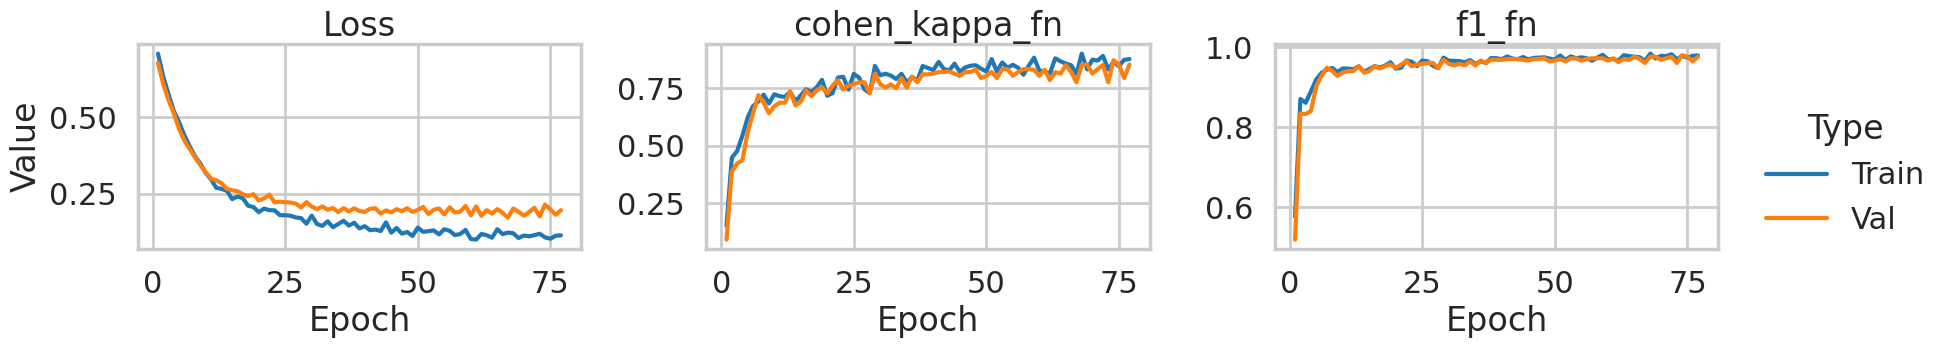

In [40]:
trainer_cnn_2.plot_epochs()

In [41]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.1377 | Test cohen_kappa_fn: 0.7613 | Test f1_fn: 0.9552


#### Finetune

In [42]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config_fine,
    train_loader_len=len(train_loader),
    total_epochs=100,
)

trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [43]:
cnn_2.unfreeze_backbone()
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.1127 | Val Loss: 0.2177 | Train cohen_kappa_fn: 0.8833 | Val cohen_kappa_fn: 0.8686 | Train f1_fn: 0.9814 | Val f1_fn: 0.9797
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.0985 | Val Loss: 0.2272 | Train cohen_kappa_fn: 0.8913 | Val cohen_kappa_fn: 0.8554 | Train f1_fn: 0.9829 | Val f1_fn: 0.9779
  ❄️ No improvement, model won't be saved!


📘 Epoch 3 | Train Loss: 0.0795 | Val Loss: 0.2031 | Train cohen_kappa_fn: 0.9212 | Val cohen_kappa_fn: 0.8815 | Train f1_fn: 0.9873 | Val f1_fn: 0.9815
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.0701 | Val Loss: 0.1769 | Train cohen_kappa_fn: 0.9070 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9851 | Val f1_fn: 0.9814
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.0590 | Val Loss: 0.1794 | Train cohen_kappa_fn: 0.9487 | Val cohen_kappa_fn: 0.8601 | Train f1_fn: 0.9918 | Val f1_fn: 0.9777
  ❄️ No improvement, model won't be saved!


📘 Epoch 6 | Train Loss: 0.0510 | Val Loss: 0.1743 | Train cohen_kappa_fn: 0.9529 | Val cohen_kappa_fn: 0.8578 | Train f1_fn: 0.9926 | Val f1_fn: 0.9778
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.0447 | Val Loss: 0.1659 | Train cohen_kappa_fn: 0.9442 | Val cohen_kappa_fn: 0.8578 | Train f1_fn: 0.9910 | Val f1_fn: 0.9778
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.0606 | Val Loss: 0.1764 | Train cohen_kappa_fn: 0.9490 | Val cohen_kappa_fn: 0.8686 | Train f1_fn: 0.9918 | Val f1_fn: 0.9797
  ❄️ No improvement, model won't be saved!


📘 Epoch 9 | Train Loss: 0.0458 | Val Loss: 0.1749 | Train cohen_kappa_fn: 0.9717 | Val cohen_kappa_fn: 0.8795 | Train f1_fn: 0.9955 | Val f1_fn: 0.9815
  ❄️ No improvement, model won't be saved!


📘 Epoch 10 | Train Loss: 0.0308 | Val Loss: 0.1551 | Train cohen_kappa_fn: 0.9764 | Val cohen_kappa_fn: 0.8686 | Train f1_fn: 0.9963 | Val f1_fn: 0.9797
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.0312 | Val Loss: 0.1631 | Train cohen_kappa_fn: 0.9669 | Val cohen_kappa_fn: 0.8907 | Train f1_fn: 0.9948 | Val f1_fn: 0.9834
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.0307 | Val Loss: 0.1637 | Train cohen_kappa_fn: 0.9905 | Val cohen_kappa_fn: 0.8707 | Train f1_fn: 0.9985 | Val f1_fn: 0.9796
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.0217 | Val Loss: 0.1616 | Train cohen_kappa_fn: 0.9445 | Val cohen_kappa_fn: 0.8496 | Train f1_fn: 0.9910 | Val f1_fn: 0.9758
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.0228 | Val Loss: 0.1372 | Train cohen_kappa_fn: 0.9717 | Val cohen_kappa_fn: 0.8623 | Train f1_fn: 0.9955 | Val f1_fn: 0.9776
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.0305 | Val Loss: 0.1816 | Train cohen_kappa_fn: 0.9952 | Val cohen_kappa_fn: 0.9135 | Train f1_fn: 0.9993 | Val f1_fn: 0.9872
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.0267 | Val Loss: 0.1559 | Train cohen_kappa_fn: 0.9854 | Val cohen_kappa_fn: 0.9003 | Train f1_fn: 0.9978 | Val f1_fn: 0.9853
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.0319 | Val Loss: 0.2730 | Train cohen_kappa_fn: 0.9805 | Val cohen_kappa_fn: 0.9003 | Train f1_fn: 0.9970 | Val f1_fn: 0.9853
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.0259 | Val Loss: 0.1981 | Train cohen_kappa_fn: 1.0000 | Val cohen_kappa_fn: 0.8925 | Train f1_fn: 1.0000 | Val f1_fn: 0.9834
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.0156 | Val Loss: 0.1833 | Train cohen_kappa_fn: 0.9810 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9970 | Val f1_fn: 0.9814
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.0142 | Val Loss: 0.2069 | Train cohen_kappa_fn: 0.9764 | Val cohen_kappa_fn: 0.8834 | Train f1_fn: 0.9963 | Val f1_fn: 0.9814
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.0109 | Val Loss: 0.2226 | Train cohen_kappa_fn: 0.9904 | Val cohen_kappa_fn: 0.8942 | Train f1_fn: 0.9985 | Val f1_fn: 0.9833
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.0142 | Val Loss: 0.2703 | Train cohen_kappa_fn: 0.9952 | Val cohen_kappa_fn: 0.9036 | Train f1_fn: 0.9993 | Val f1_fn: 0.9852
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.0073 | Val Loss: 0.3244 | Train cohen_kappa_fn: 1.0000 | Val cohen_kappa_fn: 0.8888 | Train f1_fn: 1.0000 | Val f1_fn: 0.9835
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.0090 | Val Loss: 0.3108 | Train cohen_kappa_fn: 0.9952 | Val cohen_kappa_fn: 0.9150 | Train f1_fn: 0.9993 | Val f1_fn: 0.9871
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


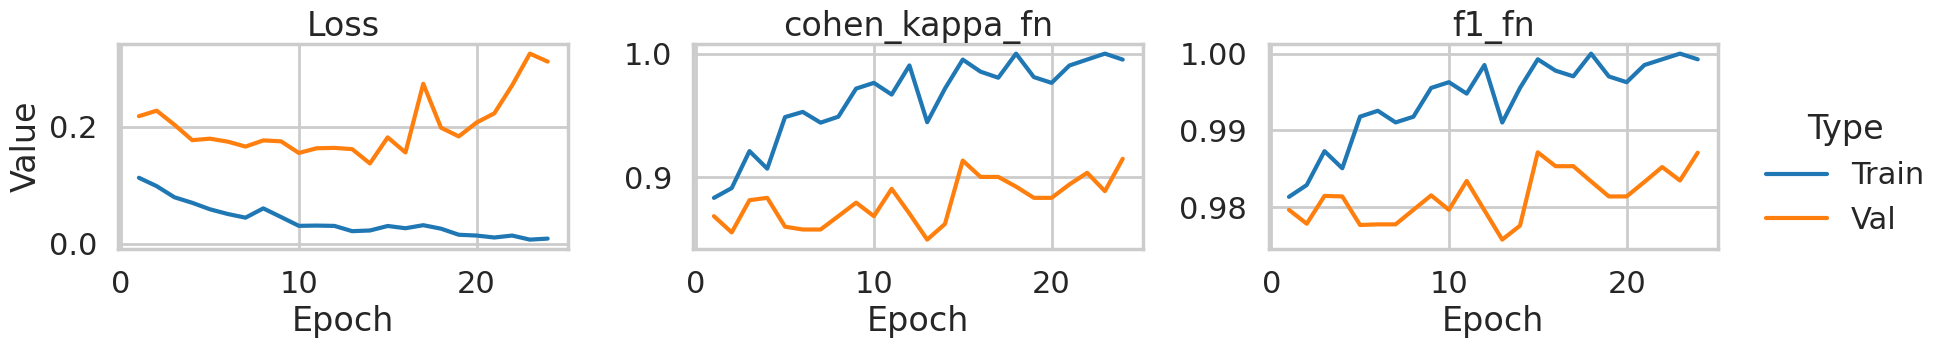

In [44]:
trainer_cnn_2.plot_epochs()

In [45]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.0836 | Test cohen_kappa_fn: 0.8733 | Test f1_fn: 0.9787


#### Visualization

In [46]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

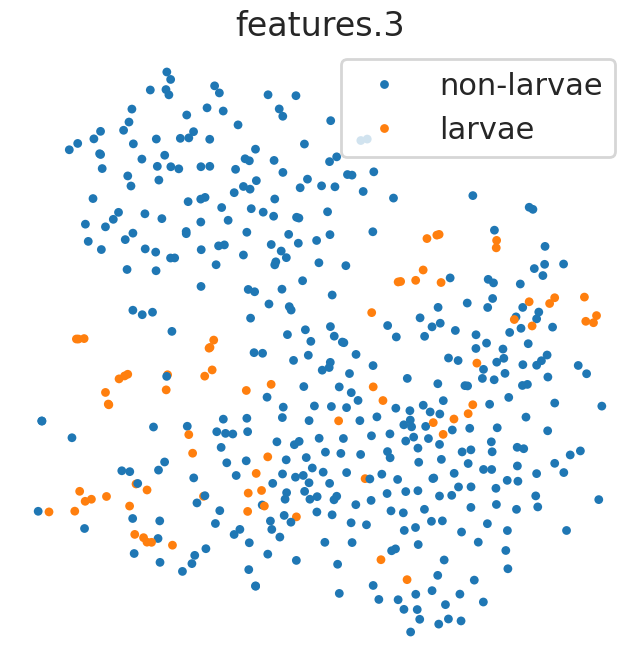

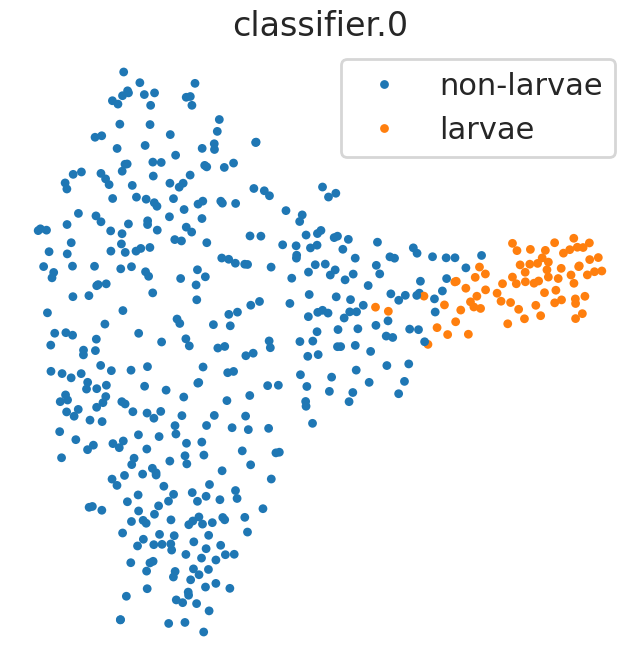

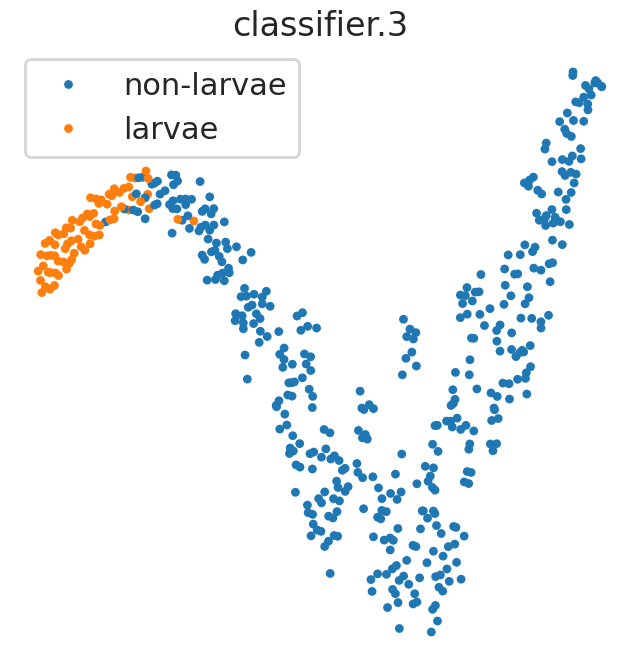

In [47]:
# Display layer representations
visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


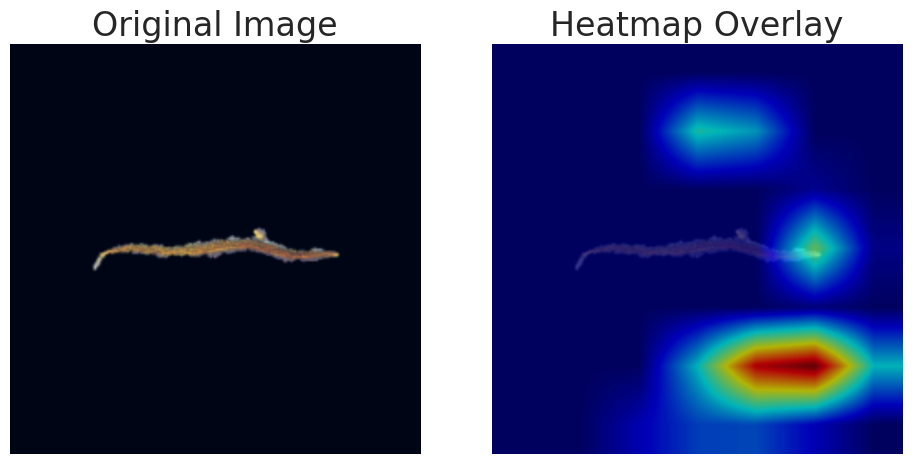

  Generating heatmap for Larvae...
  Predicted label is Larvae!


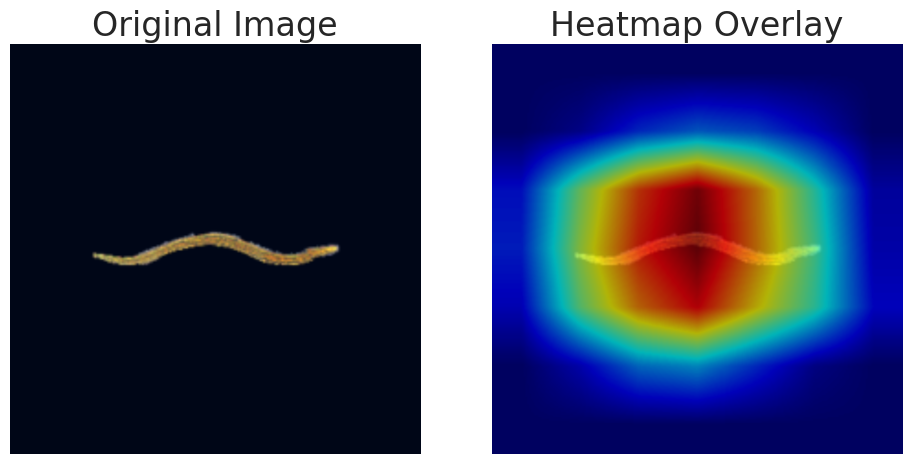

In [48]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break